In [1]:
import pathlib
import os
if 'TSL_SCHOOL_DIR' in os.environ:
    if any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ):
        raise RuntimeError('Please copy notebook to a work directory')

## Energy spectrum in an infinite medium

A simple test case for moderator materials is the calculation of the neutron spectra in equilibrium with an infinite medium. The infinite medium is reproduced with a sphere with reflective boundary conditions.

In [2]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
openmc.config['cross_sections'] = '/home/student/tsl_software/endfb-viii.0-hdf5/cross_sections.xml'

We start defining a function that returns an OpenMC model for a point source in sphere with boundary conditions, with an energy segmented tally to compute the spectra. The function takes as a parameter an OpenMC material to fill the sphere.

In [3]:
def create_model(mod_mat, NParticles=10000, E0=10):
    s1 = openmc.Sphere(r=100, boundary_type='reflective')
    c1 = openmc.Cell(region=-s1, fill=mod_mat)
    u1 = openmc.Universe(cells=[c1])
    geometry = openmc.Geometry(root=u1)
    
    source = openmc.Source()
    source.energy = openmc.stats.Discrete([E0], [1.0])
    
    settings = openmc.Settings()
    settings.source = source
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = NParticles
    settings.temperature = {'method':'nearest', 'tolerance':1000}

    tally1 = openmc.Tally()
    filter1 = openmc.CellFilter([c1])
    filter2 = openmc.EnergyFilter(np.geomspace(1e-4, 1, 120))
    tally1.scores = ['flux']
    tally1.name = 'spectrum'
    tally1.filters = [filter1, filter2]
    tallies = openmc.Tallies([tally1])
    
    return openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies)

We will define a function to extract the spectrum from the statepoint file:

In [4]:
def get_tally(spfile='statepoint.10.h5'):
    sp = openmc.StatePoint(spfile)
    tally = sp.get_tally(name='spectrum')
    df = tally.get_pandas_dataframe()
    phi_g = df['mean'].values
    E_g = df['energy high [eV]'].values
    return E_g, phi_g

We can now apply this to the calculation of spectra to different materials:

In [5]:
m1 = openmc.Material()
m1.add_elements_from_formula('H2O')
m1.set_density('g/cm3', 1.0)
m1.add_s_alpha_beta('c_H_in_H2O')

model = create_model(m1)
model.export_to_xml()

In [6]:
!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [7]:
E1, phi1 = get_tally('statepoint.10.h5')

Text(0, 0.5, 'Spectrum [au]')

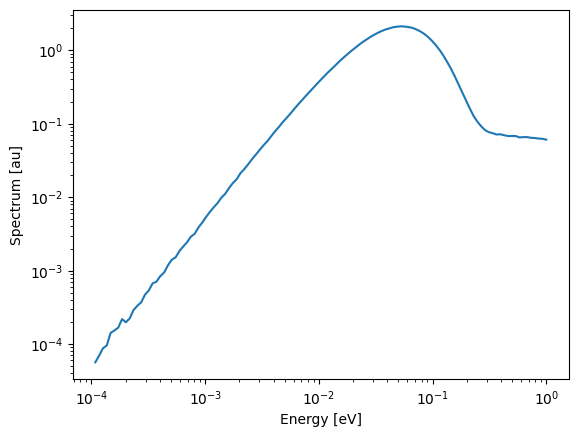

In [8]:
plt.loglog(E1,phi1)
plt.xlabel('Energy [eV]')
plt.ylabel('Spectrum [au]')

In [9]:
m1_nc = openmc.Material.from_ncrystal('LiquidWaterH2O_T293.6K.ncmat')
model = create_model(m1_nc)
model.export_to_xml()

!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

E2, phi2 = get_tally('statepoint.10.h5')

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Text(0, 0.5, 'Spectrum [au]')

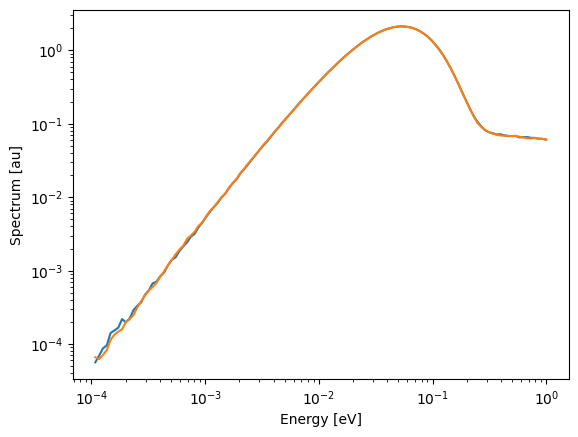

In [10]:
plt.loglog(E1,phi1)
plt.loglog(E2,phi2)
plt.xlabel('Energy [eV]')
plt.ylabel('Spectrum [au]')

In [11]:
E1, xs1 = openmc.calculate_cexs(m1, ['scatter'])
E1_nc, xs1_nc = openmc.calculate_cexs(m1_nc, ['scatter'])

NCrystal WARNING: Discarding 52 edges of provided kernel data due to missing S values.


Text(0, 0.5, 'Macroscopic XS [cm^-1]')

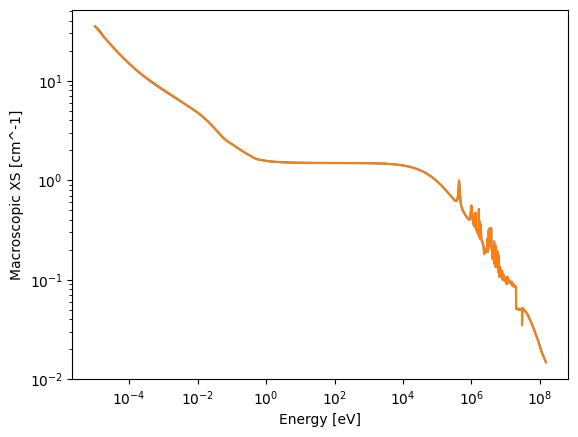

In [13]:
plt.loglog(E1, xs1[0])
plt.loglog(E1_nc, xs1_nc[0])
plt.xlabel('Energy [eV]')
plt.ylabel('Macroscopic XS [cm^-1]')